# Clustering performance

If a trusted or ground truth clustering is available, then we can compare it to a different clustering result. Let's say that two sample points in a clustering are *buddies* if they are in the same cluster, and *strangers* otherwise. 

## (Adjusted) Rand index
Let $b$ be the number of pairs that are buddies in both clusterings, and let $s$ be the number of pairs that are strangers in both clusterings. Noting that there are $\binom{n}{2}$ distinct pairs of $n$ sample points, we define the **Rand index** by

$$
\text{RI} = \frac{b+s}{\binom{n}{2}}.
$$

One good feature of the Rand index is that there is no need to find a correspondence between the clusters in the two clusterings. In fact, the clusterings need not even have the same number of clusters.

While the Rand index is not hard to understand, it's not normalized to any obvious scale. The **adjusted Rand index** is

$$
\text{ARI} = \frac{\text{RI} - E[\text{RI}]}{\text{max}(\text{RI})-E[\text{RI}]},
$$

where the mean and max operations are taken over all possible clusterings. (These values can be worked out by combinatorics.) Hence an ARI of 0 indicates no better agreement than a random clustering, and an ARI of 1 is complete agreement. 

## Silhouette coefficient

If no reference clustering (i.e., ground truth) is available, then we can use a different measurement to assess the intrinsic quality. Suppose $\bfx_i$ is a sample point. Let $\bar{b}$ be the mean distance between $\bfx_i$ and its buddies, and let $\bar{r}$ be the mean distance between $\bfx_i$ and the members of the nearest cluster of strangers. Then the **silhouette coefficient** or silhouette score of $\bfx_i$ is 

$$
S_i = \frac{\bar{r}-\bar{b}}{\max\{\bar{r},\bar{b}\}}.
$$

This value is between $-1$ (bad) and $1$ (good). Finally, the silhouette score of a cluster is the mean of the $S_i$ over the samples in that cluster.

## Toy example

We will create an artificial data set with two features and three predefined clusters.

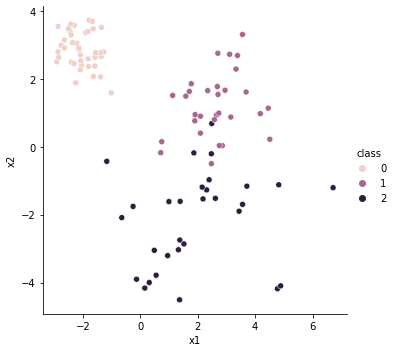

In [1]:
from sklearn.datasets import make_blobs
X,y = make_blobs(
    n_samples=[40,30,30],
    centers=[[-2,3],[3,1.5],[2,-2]],
    cluster_std=[0.5,0.9,1.5],
    random_state = 19716
    )

import pandas as pd
import seaborn as sns
blobs = pd.DataFrame({"x1":X[:,0],"x2":X[:,1],"class":y})
sns.relplot(data=blobs,x="x1",y="x2",hue="class");

As you can see above, class 2 is more dispersed than the other clusters, and, given the overlaps, a person might label a few points differently.

We will add a column to the data frame that records the silhouette score for each point.

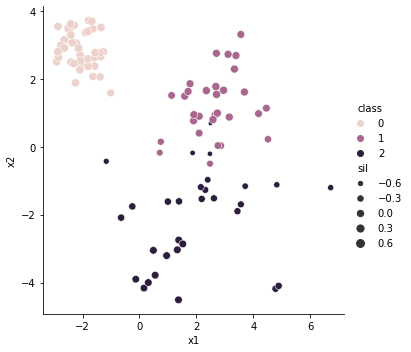

In [2]:
from sklearn.metrics import silhouette_samples
blobs["sil"] = silhouette_samples(X,y)
sns.relplot(data=blobs,x="x1",y="x2",hue="class",size="sil");

In this plot, the size of the dot shows its silhouette coefficient. Those points which don't belong comfortably with their cluster have negative scores and the smallest dots. We can find the average score in each cluster through a grouped mean:

In [3]:
blobs.groupby("class")["sil"].mean()

class
0    0.812718
1    0.551222
2    0.223225
Name: sil, dtype: float64

These values are ordered as we would expect.

Now let's create another clustering based on the quadrants of the plane.

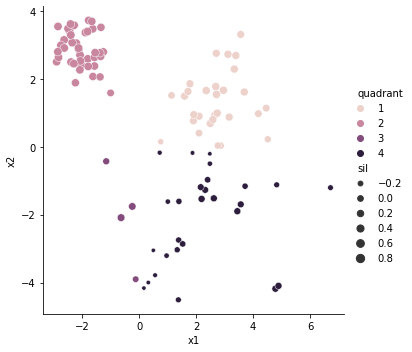

In [4]:
def quad(x,y):
    if x > 0:
        if y > 0: return 1
        else: return 4
    else:
        if y > 0: return 2
        else: return 3

blobs["quadrant"] = [quad(x,y) for (x,y) in zip(blobs.x1,blobs.x2)]
blobs["sil"] = silhouette_samples(X,blobs["quadrant"])
sns.relplot(data=blobs,x="x1",y="x2",hue="quadrant",size="sil");

In [5]:
blobs.groupby("quadrant")["sil"].mean()

quadrant
1    0.578120
2    0.808252
3    0.409983
4    0.043896
Name: sil, dtype: float64

Even though the original clustering had three classes, and there are four quadrants, we can still compare them by adjusted Rand index.

In [6]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(y,blobs["quadrant"])

0.8784845217926999

Not surprisingly, they are seen as fairly similar.

## Digits

sklearn has a well-known dataset that contains labeled handwritten digits. Let's extract the examples for just the numerals 4, 5, and 6.

In [7]:
from sklearn import datasets
digits = datasets.load_digits(as_frame=True)["frame"]
X = digits.drop("target",axis=1)
y = digits.target
keep = (y==4) | (y==5) | (y==6)
X = X[keep]
y = y[keep]
print(y.value_counts())

5    182
4    181
6    181
Name: target, dtype: int64


We can visualize the raw data. Here are some of the 6s.

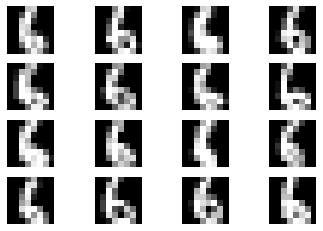

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_digits(X):
    fig, axes = plt.subplots(4,4)
    for i in range(4):
        for j in range(4):
            row = j + 4*i
            A = np.reshape(np.array(X.iloc[row,:]),(8,8))
            sns.heatmap(A,ax=axes[i,j],square=True,cmap="gray",cbar=False)
            axes[i,j].axis(False)
    return None

plot_digits(X[y==6])

A clustering method won't be able to learn from the ground truth labels. In order to set expectations, we should see how well the differently labeled examples cluster. Here is how the silhouette scores are distributed.

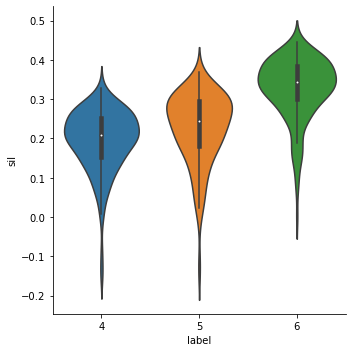

In [9]:
from sklearn.metrics import silhouette_samples
X["sil"] = silhouette_samples(X,y)
X["label"] = y.astype("category")
sns.catplot(data=X,x="label",y="sil",kind="violin");

The scores are mostly positive, which indicates some degree of clustering. The 6s in particular are fairly well-clustered. There are, however, some examples with negative clustering scores, indicating cases that might get assigned to different clusters than the labels suggest.

It's useful to keep in mind that while classification just requires us to separate different classes of examples, clustering is more demanding: examples in a cluster need to be more like each other, or the "average" cluster member, than they are like members of other clusters. We should expect that edge cases, even within the training data, will look ambiguous, and there is no ground truth to help draw the boundaries.